In [2]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, l2, create_gif, clear_temp
from modules.problems import DampedHarmonicOscillator
from modules.training import train

import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
import torch.nn as nn

class SinActivation(nn.Module):
    def __init__(self, alpha=1, learnable=False):
        super(SinActivation, self).__init__()
        if learnable:
            self.alpha = nn.Parameter(torch.as_tensor(alpha))
        else:
            self.alpha = alpha
    def forward(self, x):
        return torch.sin(x)
    
class Swish(nn.Module):
    def __init__(self, beta=1, learnable=False):
        super(Swish, self).__init__()
        if learnable:
            self.beta = nn.Parameter(torch.as_tensor(beta))
        else:
            self.beta = beta
    def forward(self, x):
        return x * nn.functional.sigmoid(self.beta * x)

In [4]:
clear_temp()

In [27]:
def f(problem, N_F, loss_history=None):
    zero = torch.tensor([0.], requires_grad=True).to(device)
    t = torch.linspace(0, problem.T, N_F, requires_grad=True).reshape(-1, 1)
    return zero, t

problem_number = 4
problem = DampedHarmonicOscillator.get_problem(problem_number)
name = f'dho{problem_number}_swish'

L, W = 2, 32
model = FeedForwardNetwork(L, W, activation=Swish(beta=1))

num_iters = 5000
plot_every = 100

train(
    problem,
    model,
    hyperparameters={
        'optimizer': torch.optim.Adam,
        'arguments': {'lr': 1e-2},
        'scheduler': {
            'rule': torch.optim.lr_scheduler.StepLR, 
            'parameters': {'step_size': 10000}
            },
        'num_iters': num_iters,
        'collocation_points': {
            'sample_every': 0,
            'N_points': {'N_F': 4096},
            'generation_function': f
        },
        'coefs': [[0.7], [0.3]],
        'dynamic_coefs': -1,
        'coef_func': None
    },
    plotting_params={
        'save_dir': './.temp/',
        'plot_every': plot_every,
        'size': (5, 3)
    },
    name=name,
    print_every=500
)

print('Creating gif...')
create_gif(
    images=[f'./.temp/{name}_iteration_{i}.jpg' for i in range(0, num_iters, plot_every)], 
    path=f'../images/animations/dho/{name}_test.gif'
)

Iter ____0 	 9.75553009573431
Iter __500 	 7.686487452383724
Iter _1000 	 7.432148360029105
Iter _1500 	 7.184044291856484
Iter _2000 	 6.763275266679396
Iter _2500 	 6.444803395706137
Iter _3000 	 5.882985487581209
Iter _3500 	 5.428867308401563
Iter _4000 	 5.006672712581339
Iter _4500 	 4.501058755103625
Creating gif...


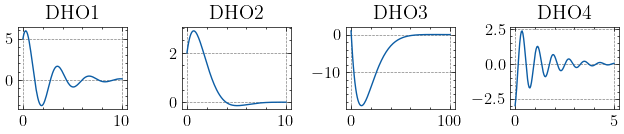

In [80]:
problems = [DampedHarmonicOscillator.get_problem(i) for i in range(1, 5)]

size = (3.5, 3)
fig, axs = plt.subplots(2, 2, figsize=size)
for (i, j), (ind, problem) in zip([(0, 0), (0, 1), (1, 0), (1, 1)], enumerate(problems)):
    axs[i, j].plot(problem.t, problem.solution[0])
    axs[i, j].plot(problem.t, problem.solution[1])
    
    test_model = torch.load(f'./studies/diff_{ind + 1}_best_model.pt', map_location='cpu')

    preds = test_model(problem.t.reshape(-1, 1)).detach().numpy()
    x = preds[:,0].flatten()
    y = preds[:,1].flatten()
    
    axs[i, j].plot(problem.t, x, linestyle='dashed')
    axs[i, j].plot(problem.t, y, linestyle='dashed')
    
    axs[i, j].title.set_text(f'LV{ind+1}')
    
plt.tight_layout()

plt.savefig('../images/lv_solutions_grid.png', dpi=250)
plt.show()

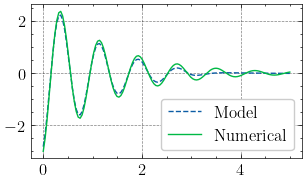

In [185]:
problem = get_problem(4)
test_model = torch.load('./studies/dho_4_best_model.pt', map_location='cpu')
predictions = test_model(problem.t.reshape(-1, 1)).detach().flatten().cpu().numpy()

fig = plt.figure(figsize=(3.5, 2))
plt.plot(problem.t, predictions, label='Model', linestyle='dashed')
plt.plot(problem.t, problem.solution, label='Numerical')
plt.legend()
plt.savefig('../images/dho_4_solution.png', dpi=250)